In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns


# Spherical Method


=== Baseline Model Results ===
Average similarity change: 0.07979530339490395
Max similarity change: 0.39007009434878537

=== Spherical Model Results ===
Semantic Coherence by Group:
Animal group: 0.625
Nature group: 0.527
Human group: 0.588


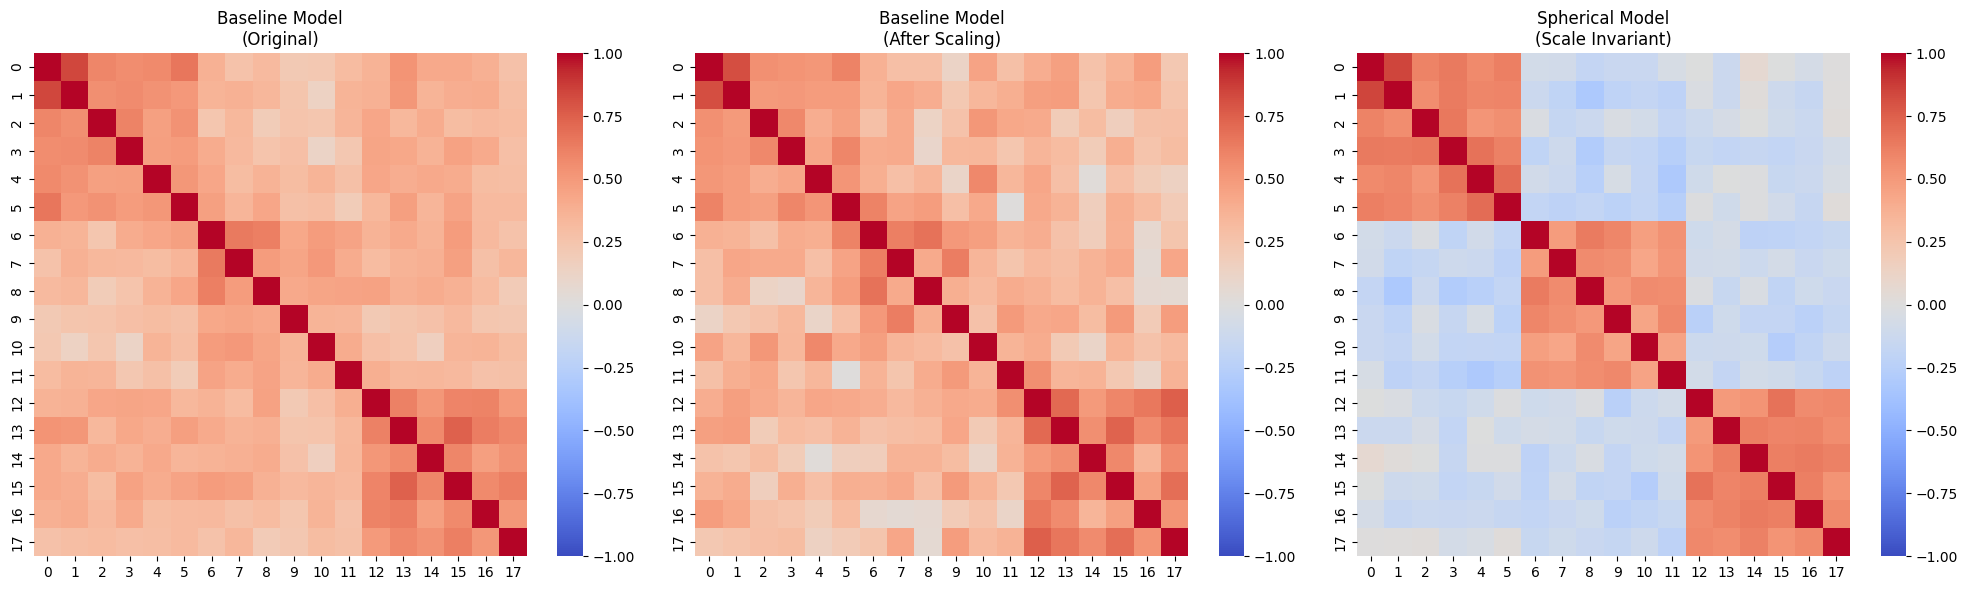


=== Detailed Comparison ===

Baseline Model (Original):
Animal_internal: 0.564
Animal_external: 0.299
Nature_internal: 0.458
Nature_external: nan
Human_internal: 0.577
Human_external: 0.380

Spherical Model:
Animal_internal: 0.625
Animal_external: -0.167
Nature_internal: 0.527
Nature_external: nan
Human_internal: 0.588
Human_external: -0.073


/var/folders/py/19s8w1_s0_g5bw1c_0qmm1s80000gn/T/ipykernel_44821/2533282794.py:259: RuntimeWarning: Mean of empty slice.
  metrics[f'{name}_external'] = between_sim.mean()
/Users/eli/code/cosine_sim_analysis/.venv/lib/python3.11/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


In [16]:
# Step 1: Create structured test data with semantic groups
sentences = [
    # Animal group
    "The cat chases the mouse",
    "The dog chases the cat",
    "The lion hunts the gazelle", 
    "The wolf hunts the deer",
    "The tiger stalks its prey",
    "The fox catches the rabbit",
    # Nature group
    "The tree sways in the wind",
    "The flower blooms in spring", 
    "The grass grows in sunlight",
    "The river flows downstream",
    "The leaves rustle gently",
    "The rain falls softly",
    # Human group
    "The teacher writes on board",
    "The student reads the book",
    "The worker builds the house",
    "The chef cooks the meal", 
    "The artist paints the canvas",
    "The doctor helps patients"
]

# Assign group labels (0: Animal, 1: Nature, 2: Human)
groups = [0] * 6 + [1] * 6 + [2] * 6

def set_seeds(seed=42):
    """Set random seeds for reproducibility"""
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set random seeds for reproducibility
set_seeds()

class EmbeddingModel(nn.Module):
    """Base embedding model that computes mean embeddings for sentences"""
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        
    def forward(self, x, normalize_output=False):
        # Get embeddings
        embedded = self.embedding(x)
        
        # Create mask for padding tokens
        mask = (x != 0).float().unsqueeze(-1)
        
        # Apply mask and compute mean embedding
        summed = (embedded * mask).sum(dim=1)
        lengths = mask.sum(dim=1)
        lengths[lengths == 0] = 1  # Avoid division by zero
        averaged = summed / lengths
        
        if normalize_output:
            # Normalize if requested
            norms = torch.norm(averaged, p=2, dim=1, keepdim=True)
            averaged = averaged / norms
                
        return averaged

class SphericalEmbeddingModel(nn.Module):
    """Embedding model that projects embeddings onto a unit sphere"""
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        
    def forward(self, x):
        # Get embeddings
        embedded = self.embedding(x)
        
        # Create mask for padding tokens
        mask = (x != 0).float().unsqueeze(-1)
        
        # Apply mask and compute mean embedding
        summed = (embedded * mask).sum(dim=1)
        lengths = mask.sum(dim=1)
        lengths[lengths == 0] = 1  # Avoid division by zero
        averaged = summed / lengths
        
        # Project onto unit sphere
        normalized = F.normalize(averaged, p=2, dim=1)
        return normalized
    
    def get_normalized_embedding_matrix(self):
        """Get the embedding matrix projected onto unit sphere"""
        return F.normalize(self.embedding.weight, p=2, dim=1)

def prepare_data(sentences):
    """Convert sentences to token indices using a simple vocabulary"""
    # Build vocabulary from sentences
    words = set()
    for sentence in sentences:
        words.update(sentence.lower().split())
    vocab = {word: idx+1 for idx, word in enumerate(sorted(words))}
        
    # Convert sentences to token indices
    encoded = []
    for sentence in sentences:
        encoded.append([vocab[word.lower()] for word in sentence.split()])
        
    return vocab, encoded

def train_model(encoded_sentences, model_params):
    """Train basic embedding model using triplet loss"""
    vocab_size = max(max(sent) for sent in encoded_sentences) + 1
    model = EmbeddingModel(vocab_size, model_params['embedding_dim'])
        
    # Convert sentences to tensors
    data = [torch.tensor(sent, dtype=torch.long) for sent in encoded_sentences]
    optimizer = optim.Adam(model.parameters(), lr=model_params['lr'])
        
    # Training loop with triplet loss
    for epoch in range(model_params['epochs']):
        total_loss = 0
        for i, anchor in enumerate(data):
            # Sample positive examples (same group) and negative examples (different groups)
            pos_indices = [j for j, g in enumerate(groups) if g == groups[i] and j != i]
            neg_indices = [j for j, g in enumerate(groups) if g != groups[i]]
                
            # Get anchor embedding
            anchor_emb = model(anchor.unsqueeze(0))
            
            # Get positive embeddings
            pos_emb_list = [model(data[j].unsqueeze(0)) for j in pos_indices]
            if pos_emb_list:
                pos_emb = torch.cat(pos_emb_list, dim=0)
            else:
                continue
                
            # Get negative embeddings
            neg_emb_list = [model(data[j].unsqueeze(0)) for j in neg_indices]
            if neg_emb_list:
                neg_emb = torch.cat(neg_emb_list, dim=0)
            else:
                continue
                
            # Compute similarities
            pos_sim = torch.mm(anchor_emb, pos_emb.t())
            neg_sim = torch.mm(anchor_emb, neg_emb.t())
                
            # Compute triplet loss
            loss = torch.mean(torch.relu(neg_sim.t() - pos_sim + model_params['margin']))
                
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            
    return model

def train_spherical_model(encoded_sentences, model_params):
    """Train embedding model with spherical normalization using triplet loss"""
    vocab_size = max(max(sent) for sent in encoded_sentences) + 1
    model = SphericalEmbeddingModel(vocab_size, model_params['embedding_dim'])
    
    # Convert sentences to tensors
    data = [torch.tensor(sent, dtype=torch.long) for sent in encoded_sentences]
    optimizer = optim.Adam(model.parameters(), lr=model_params['lr'])
    
    # Training loop with triplet loss
    for epoch in range(model_params['epochs']):
        total_loss = 0
        for i, anchor in enumerate(data):
            # Sample positive examples (same group) and negative examples (different groups)
            pos_indices = [j for j, g in enumerate(groups) if g == groups[i] and j != i]
            neg_indices = [j for j, g in enumerate(groups) if g != groups[i]]
            
            # Get normalized embeddings
            anchor_emb = model(anchor.unsqueeze(0))
            
            # Get positive embeddings
            pos_emb_list = [model(data[j].unsqueeze(0)) for j in pos_indices]
            if pos_emb_list:
                pos_emb = torch.cat(pos_emb_list, dim=0)
            else:
                continue
            
            # Get negative embeddings
            neg_emb_list = [model(data[j].unsqueeze(0)) for j in neg_indices]
            if neg_emb_list:
                neg_emb = torch.cat(neg_emb_list, dim=0)
            else:
                continue
            
            # Compute cosine similarities (dot product of normalized vectors)
            pos_sim = torch.mm(anchor_emb, pos_emb.t())
            neg_sim = torch.mm(anchor_emb, neg_emb.t())
            
            # Compute triplet loss
            loss = torch.mean(torch.relu(neg_sim.t() - pos_sim + model_params['margin']))
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            
    return model

def analyze_similarities(model, encoded_sentences, scaling_factor=100):
    """Analyze embedding similarities before and after dimension scaling"""
    with torch.no_grad():
        # Get original embeddings
        embeddings = []
        for sent in encoded_sentences:
            emb = model(torch.tensor(sent).unsqueeze(0))
            embeddings.append(emb[0].numpy())
        embeddings = np.array(embeddings)
            
        # Calculate original cosine similarities
        original_sim = cosine_similarity(embeddings)
            
        # Scale first half of dimensions down and second half up
        dim = embeddings.shape[1]
        scaling = np.ones(dim)
        scaling[:dim//2] = 1/scaling_factor
        scaling[dim//2:] = scaling_factor
            
        scaled_embeddings = embeddings * scaling
        scaled_sim = cosine_similarity(scaled_embeddings)
            
        return original_sim, scaled_sim

def analyze_spherical_similarities(model, encoded_sentences):
    """Analyze similarities for spherical embeddings"""
    with torch.no_grad():
        # Get normalized embeddings
        embeddings = []
        for sent in encoded_sentences:
            emb = model(torch.tensor(sent).unsqueeze(0))
            embeddings.append(emb[0].numpy())
        embeddings = np.array(embeddings)
        
        # Compute cosine similarities
        similarities = np.dot(embeddings, embeddings.T)
        
        return similarities

def compute_group_metrics(similarities):
    """Compute within-group and between-group similarity metrics"""
    metrics = {}
    for group_id, name in enumerate(['Animal', 'Nature', 'Human']):
        start_idx = group_id * 6
        end_idx = start_idx + 6
        
        # Calculate within-group similarity
        group_sim = similarities[start_idx:end_idx, start_idx:end_idx]
        mask = ~np.eye(group_sim.shape[0], dtype=bool)
        metrics[f'{name}_internal'] = group_sim[mask].mean()
        
        # Calculate between-group similarity with next group
        next_start = (group_id + 1) * 6 % 18
        next_end = (group_id + 2) * 6 % 18
        between_sim = similarities[start_idx:end_idx, next_start:next_end]
        metrics[f'{name}_external'] = between_sim.mean()
    
    return metrics

# Main execution
vocab, encoded_sentences = prepare_data(sentences)

# Model hyperparameters
model_params = {
    'embedding_dim': 50,
    'lr': 0.001,
    'epochs': 100,
    'margin': 0.5,
}

# Train baseline model
base_model = train_model(encoded_sentences, model_params)
base_orig_sim, base_scaled_sim = analyze_similarities(base_model, encoded_sentences)

# Train spherical model
spherical_model = train_spherical_model(encoded_sentences, model_params)
spherical_sim = analyze_spherical_similarities(spherical_model, encoded_sentences)

# Print baseline model results
print("\n=== Baseline Model Results ===")
print("Average similarity change:", np.mean(np.abs(base_scaled_sim - base_orig_sim)))
print("Max similarity change:", np.max(np.abs(base_scaled_sim - base_orig_sim)))

# Print spherical model results
print("\n=== Spherical Model Results ===")
print("Semantic Coherence by Group:")
for group_id, name in enumerate(['Animal', 'Nature', 'Human']):
    start_idx = group_id * 6
    end_idx = start_idx + 6
    group_similarities = spherical_sim[start_idx:end_idx, start_idx:end_idx]
    mask = ~np.eye(group_similarities.shape[0], dtype=bool)
    avg_similarity = group_similarities[mask].mean()
    print(f"{name} group: {avg_similarity:.3f}")

# Visualize similarity matrices
plt.figure(figsize=(20, 6))

plt.subplot(131)
sns.heatmap(base_orig_sim, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Baseline Model\n(Original)")

plt.subplot(132)
sns.heatmap(base_scaled_sim, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Baseline Model\n(After Scaling)")

plt.subplot(133)
sns.heatmap(spherical_sim, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Spherical Model\n(Scale Invariant)")

plt.tight_layout()
plt.show()

# Print detailed metrics
print("\n=== Detailed Comparison ===")
print("\nBaseline Model (Original):")
base_metrics = compute_group_metrics(base_orig_sim)
for k, v in base_metrics.items():
    print(f"{k}: {v:.3f}")

print("\nSpherical Model:")
spherical_metrics = compute_group_metrics(spherical_sim)
for k, v in spherical_metrics.items():
    print(f"{k}: {v:.3f}")

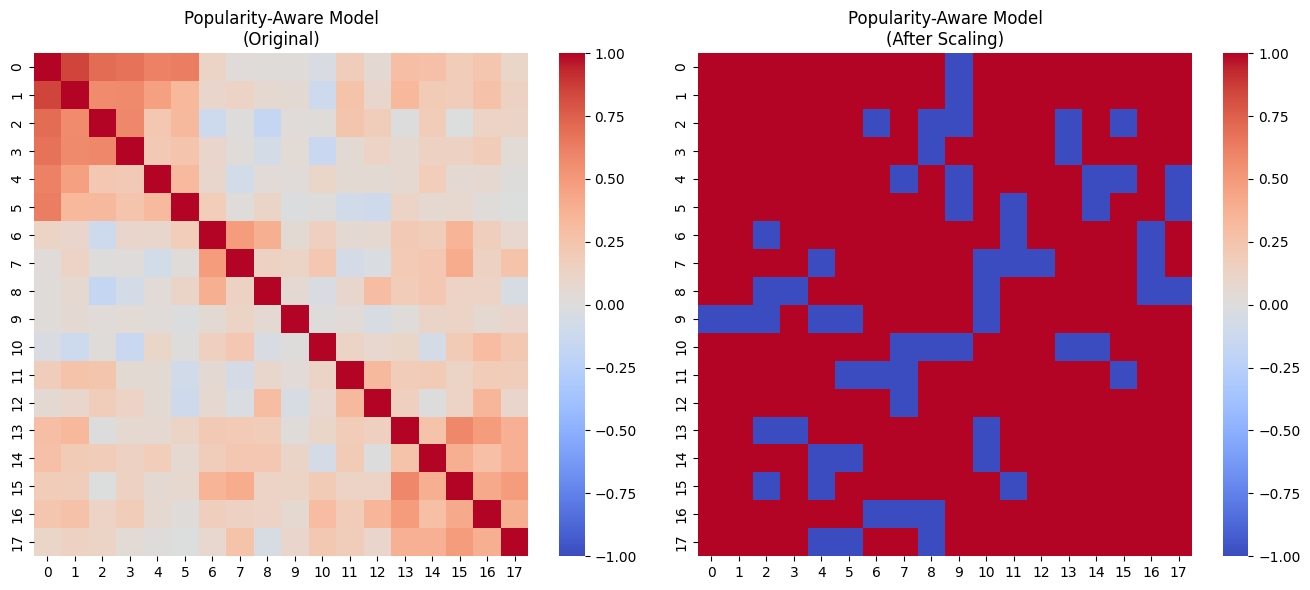


=== Detailed Comparison ===

Popularity-Aware Model:
Animal_internal: 0.488
Animal_external: 0.036
Nature_internal: 0.123
Nature_external: nan
Human_internal: 0.320
Human_external: 0.120


/var/folders/py/19s8w1_s0_g5bw1c_0qmm1s80000gn/T/ipykernel_44821/2533282794.py:259: RuntimeWarning: Mean of empty slice.
  metrics[f'{name}_external'] = between_sim.mean()
/Users/eli/code/cosine_sim_analysis/.venv/lib/python3.11/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


In [20]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# import torch.nn.functional as F
# from torch.utils.data import Dataset, DataLoader
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns

# # [Previous sentences and groups definitions remain the same]

# def set_seeds(seed=42):
#     """Set random seeds for reproducibility"""
#     torch.manual_seed(seed)
#     torch.cuda.manual_seed_all(seed)
#     np.random.seed(seed)
#     torch.backends.cudnn.deterministic = True
#     torch.backends.cudnn.benchmark = False

# class PopularityAwareEmbeddingModel(nn.Module):
#     """Embedding model that handles popularity bias during training"""
#     def __init__(self, vocab_size, embedding_dim, popularity_counts=None):
#         super().__init__()
#         self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        
#         # Compute sampling probabilities and IPS weights
#         if popularity_counts is not None:
#             probs = popularity_counts / popularity_counts.sum()
#             self.sampling_probs = probs ** 0.75  # Word2Vec approach
#             self.ips_weights = 1 / (probs + 1e-8)
#         else:
#             self.sampling_probs = None
#             self.ips_weights = None
            
#     def forward(self, x):
#         embedded = self.embedding(x)
#         mask = (x != 0).float().unsqueeze(-1)
#         summed = (embedded * mask).sum(dim=1)
#         lengths = mask.sum(dim=1)
#         lengths[lengths == 0] = 1
#         averaged = summed / lengths
#         return F.normalize(averaged, p=2, dim=1)  # L2 normalize embeddings
    
#     def get_negative_samples(self, batch_size, num_negative):
#         if self.sampling_probs is None:
#             return torch.randint(1, self.embedding.num_embeddings, (batch_size, num_negative))
#         return torch.multinomial(
#             self.sampling_probs, 
#             batch_size * num_negative, 
#             replacement=True
#         ).view(batch_size, num_negative)

# def prepare_data(sentences):
#     """Convert sentences to token indices and compute popularity counts"""
#     words = set()
#     word_counts = {}
    
#     # First pass: build vocabulary and count words
#     for sentence in sentences:
#         for word in sentence.lower().split():
#             words.add(word)
#             word_counts[word] = word_counts.get(word, 0) + 1
    
#     # Create vocabulary mapping
#     vocab = {word: idx+1 for idx, word in enumerate(sorted(words))}
    
#     # Create popularity counts tensor
#     popularity_counts = torch.zeros(len(vocab) + 1)  # +1 for padding idx
#     for word, count in word_counts.items():
#         popularity_counts[vocab[word]] = count
    
#     # Convert sentences to token indices
#     encoded = []
#     for sentence in sentences:
#         encoded.append([vocab[word.lower()] for word in sentence.split()])
        
#     return vocab, encoded, popularity_counts

# def train_popularity_aware_model(encoded_sentences, model_params, popularity_counts):
#     """Train model with popularity-aware negative sampling and IPS"""
#     vocab_size = max(max(sent) for sent in encoded_sentences) + 1
#     model = PopularityAwareEmbeddingModel(
#         vocab_size, 
#         model_params['embedding_dim'],
#         popularity_counts
#     )
    
#     data = [torch.tensor(sent, dtype=torch.long) for sent in encoded_sentences]
#     optimizer = optim.Adam(model.parameters(), lr=model_params['lr'])
    
#     for epoch in range(model_params['epochs']):
#         total_loss = 0
#         for i, anchor in enumerate(data):
#             # Get anchor embedding
#             anchor_emb = model(anchor.unsqueeze(0))
            
#             # Sample positive examples (same group)
#             group_indices = [j for j, g in enumerate(groups) if g == groups[i] and j != i]
#             if not group_indices:  # Skip if no positive examples
#                 continue
                
#             # Sample subset of positive examples if too many
#             pos_indices = np.random.choice(group_indices, min(len(group_indices), 5), replace=False)
#             pos_emb_list = [model(data[j].unsqueeze(0)) for j in pos_indices]
#             pos_emb = torch.cat(pos_emb_list, dim=0)
            
#             # Get negative samples using popularity-aware sampling
#             neg_indices = model.get_negative_samples(1, len(pos_indices)).squeeze(0)
#             # Ensure indices are within valid range
#             neg_indices = neg_indices % len(data)  # Wrap around if index too large
#             neg_emb_list = [model(data[j].unsqueeze(0)) for j in neg_indices]
#             neg_emb = torch.cat(neg_emb_list, dim=0)
            
#             # Compute similarities
#             pos_sim = torch.mm(anchor_emb, pos_emb.t())
#             neg_sim = torch.mm(anchor_emb, neg_emb.t())
            
#             # Apply IPS weights to the loss
#             if model.ips_weights is not None:
#                 pos_weights = model.ips_weights[pos_indices]
#                 neg_weights = model.ips_weights[neg_indices]
#                 loss = torch.mean(
#                     pos_weights * torch.relu(neg_sim.t() - pos_sim + model_params['margin'])
#                 )
#             else:
#                 loss = torch.mean(torch.relu(neg_sim.t() - pos_sim + model_params['margin']))
            
#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()
#             total_loss += loss.item()
            
#     return model

# def analyze_similarities(model, encoded_sentences, scaling_factor=100):
#     """Analyze embedding similarities before and after dimension scaling"""
#     with torch.no_grad():
#         embeddings = []
#         for sent in encoded_sentences:
#             sent_tensor = torch.tensor(sent, dtype=torch.long).unsqueeze(0)
#             emb = model(sent_tensor)
#             embeddings.append(emb[0].numpy())
#         embeddings = np.array(embeddings)
        
#         # Compute cosine similarities directly
#         original_sim = np.matmul(embeddings, embeddings.T)
        
#         # Scale dimensions
#         dim = embeddings.shape[1]
#         scaling = np.ones(dim)
#         scaling[:dim//2] = 1/scaling_factor
#         scaling[dim//2:] = scaling_factor
        
#         scaled_embeddings = embeddings * scaling
#         scaled_sim = np.matmul(scaled_embeddings, scaled_embeddings.T)
        
#         return original_sim, scaled_sim

# # Main execution
# set_seeds()  # Set random seeds for reproducibility
# vocab, encoded_sentences, popularity_counts = prepare_data(sentences)

# model_params = {
#     'embedding_dim': 50,
#     'lr': 0.001,
#     'epochs': 100,
#     'margin': 0.5,
# }

# # Train popularity-aware model
# pop_aware_model = train_popularity_aware_model(encoded_sentences, model_params, popularity_counts)
# pop_orig_sim, pop_scaled_sim = analyze_similarities(pop_aware_model, encoded_sentences)

# # Visualization and metrics
# plt.figure(figsize=(20, 6))

# plt.subplot(131)
# sns.heatmap(pop_orig_sim, cmap='coolwarm', vmin=-1, vmax=1)
# plt.title("Popularity-Aware Model\n(Original)")

# plt.subplot(132)
# sns.heatmap(pop_scaled_sim, cmap='coolwarm', vmin=-1, vmax=1)
# plt.title("Popularity-Aware Model\n(After Scaling)")

# plt.tight_layout()
# plt.show()

# # Print detailed metrics
# print("\n=== Detailed Comparison ===")
# print("\nPopularity-Aware Model:")
# pop_metrics = compute_group_metrics(pop_orig_sim)
# for k, v in pop_metrics.items():
#     print(f"{k}: {v:.3f}")

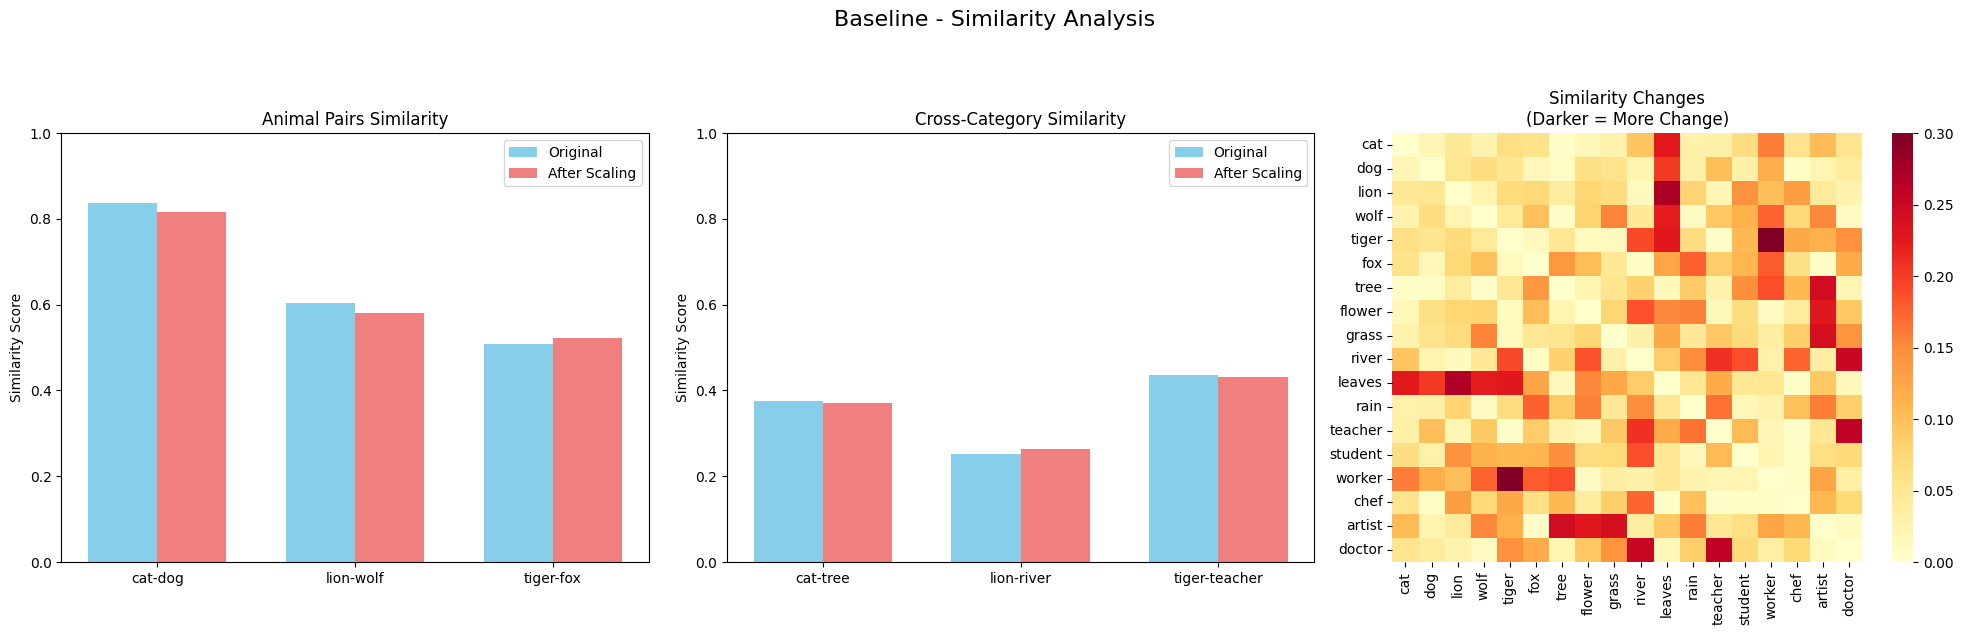


Baseline Key Metrics:
Average similarity change: 0.080
Max similarity change: 0.390
--------------------------------------------------


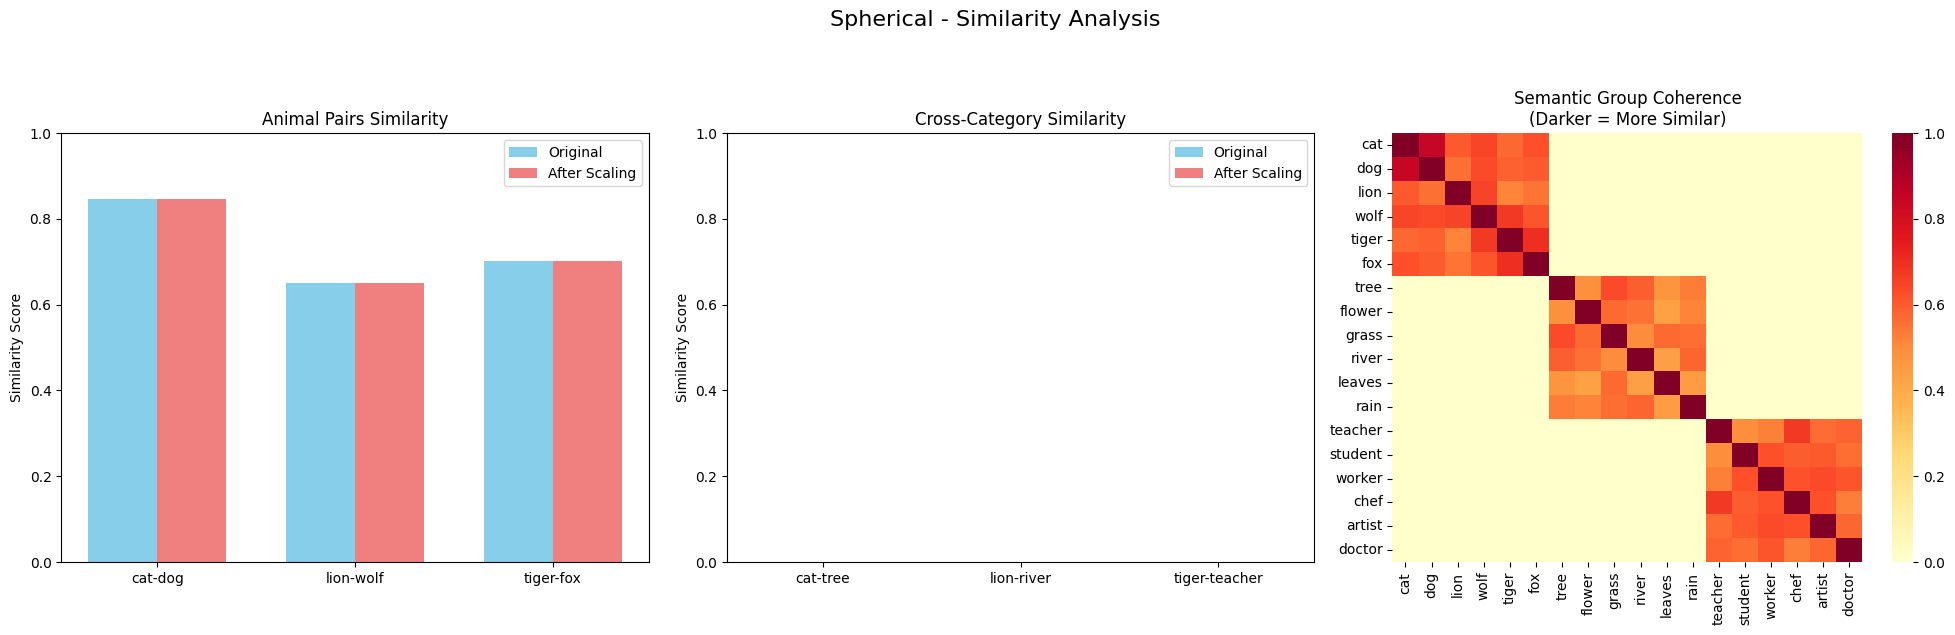


Spherical Key Metrics:
Average within-group similarity: 0.580
Average between-group similarity: -0.126
Semantic separation: 0.706
--------------------------------------------------


In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def visualize_similarity_comparison(sentences, models_data):
    """
    Visualizes similarity comparisons between different model variants.
    
    Args:
        sentences: List of input sentences used for embeddings
        models_data: List of tuples (model_name, original_sim, scaled_sim) containing
                    similarity matrices for each model variant
    """
    for model_name, original_sim, scaled_sim in models_data:
        # Create figure with three subplots for different analyses
        fig = plt.figure(figsize=(20, 6))
        
        # 1. Animal Group Similarity Analysis
        ax1 = plt.subplot(131)
        
        # Define animal pairs to compare
        animal_pairs = [
            ("cat-dog", (0, 1)),
            ("lion-wolf", (2, 3)), 
            ("tiger-fox", (4, 5))
        ]
        
        # Extract similarities for each animal pair
        pair_names = []
        orig_sims = []
        scaled_sims = []
        for name, (i, j) in animal_pairs:
            pair_names.append(name)
            orig_sims.append(original_sim[i][j])
            scaled_sims.append(scaled_sim[i][j])
        
        # Plot paired bar chart
        x = np.arange(len(pair_names))
        width = 0.35
        ax1.bar(x - width/2, orig_sims, width, label='Original', color='skyblue')
        ax1.bar(x + width/2, scaled_sims, width, label='After Scaling', color='lightcoral')
        
        ax1.set_ylabel('Similarity Score')
        ax1.set_title('Animal Pairs Similarity')
        ax1.set_xticks(x)
        ax1.set_xticklabels(pair_names)
        ax1.legend()
        ax1.set_ylim(0, 1)
        
        # 2. Cross-Category Similarity Analysis
        ax2 = plt.subplot(132)
        
        # Define cross-category pairs to compare
        cross_pairs = [
            ("cat-tree", (0, 6)),
            ("lion-river", (2, 9)),
            ("tiger-teacher", (4, 12))
        ]
        
        # Extract similarities for cross-category pairs
        cross_names = []
        cross_orig = []
        cross_scaled = []
        for name, (i, j) in cross_pairs:
            cross_names.append(name)
            cross_orig.append(original_sim[i][j])
            cross_scaled.append(scaled_sim[i][j])
        
        # Plot paired bar chart
        x = np.arange(len(cross_names))
        ax2.bar(x - width/2, cross_orig, width, label='Original', color='skyblue')
        ax2.bar(x + width/2, cross_scaled, width, label='After Scaling', color='lightcoral')
        
        ax2.set_ylabel('Similarity Score')
        ax2.set_title('Cross-Category Similarity')
        ax2.set_xticks(x)
        ax2.set_xticklabels(cross_names)
        ax2.legend()
        ax2.set_ylim(0, 1)
        
        # 3. Model-Specific Analysis
        ax3 = plt.subplot(133)
        
        if model_name == "Spherical":
            # For spherical model: visualize semantic group coherence
            group_similarities = np.zeros_like(original_sim)
            for i in range(len(sentences)):
                for j in range(len(sentences)):
                    if groups[i] == groups[j]:
                        group_similarities[i,j] = 1
            
            sns.heatmap(original_sim * group_similarities,
                       ax=ax3,
                       cmap='YlOrRd',
                       vmin=0,
                       vmax=1,
                       xticklabels=[s.split()[1] for s in sentences],
                       yticklabels=[s.split()[1] for s in sentences])
            ax3.set_title('Semantic Group Coherence\n(Darker = More Similar)')
        else:
            # For baseline model: visualize stability under scaling
            similarity_changes = np.abs(scaled_sim - original_sim)
            sns.heatmap(similarity_changes,
                       ax=ax3,
                       cmap='YlOrRd',
                       vmin=0,
                       vmax=0.3,
                       xticklabels=[s.split()[1] for s in sentences],
                       yticklabels=[s.split()[1] for s in sentences])
            ax3.set_title('Similarity Changes\n(Darker = More Change)')
        
        plt.suptitle(f'{model_name} - Similarity Analysis', fontsize=16, y=1.05)
        plt.tight_layout()
        plt.show()
        
        # Print quantitative metrics
        print(f"\n{model_name} Key Metrics:")
        if model_name == "Spherical":
            # Calculate within-group and between-group similarities
            within_group_sim = []
            between_group_sim = []
            for i in range(len(sentences)):
                for j in range(i+1, len(sentences)):
                    sim = original_sim[i][j]
                    if groups[i] == groups[j]:
                        within_group_sim.append(sim)
                    else:
                        between_group_sim.append(sim)
            print(f"Average within-group similarity: {np.mean(within_group_sim):.3f}")
            print(f"Average between-group similarity: {np.mean(between_group_sim):.3f}")
            print(f"Semantic separation: {np.mean(within_group_sim) - np.mean(between_group_sim):.3f}")
        else:
            print(f"Average similarity change: {np.mean(np.abs(scaled_sim - original_sim)):.3f}")
            print(f"Max similarity change: {np.max(np.abs(scaled_sim - original_sim)):.3f}")
        print("-" * 50)

# Run visualization for baseline and spherical models
models_data = [
    ("Baseline", base_orig_sim, base_scaled_sim),
    ("Spherical", spherical_sim, spherical_sim)  # Same matrix used twice since scaling has no effect
]

visualize_similarity_comparison(sentences, models_data)

# Sentence Tranformers


=== Original Embeddings (No Normalization) ===
Animal_internal: 0.396
Animal_external: 0.048
Nature_internal: 0.234
Nature_external: 0.059
Human_internal: 0.131
Human_external: 0.028

=== After Scaling Embeddings ===
Animal_internal: 0.398
Animal_external: 0.050
Nature_internal: 0.218
Nature_external: 0.064
Human_internal: 0.118
Human_external: 0.046

=== After Normalization ===
Animal_internal: 0.396
Animal_external: 0.048
Nature_internal: 0.234
Nature_external: 0.059
Human_internal: 0.131
Human_external: 0.028


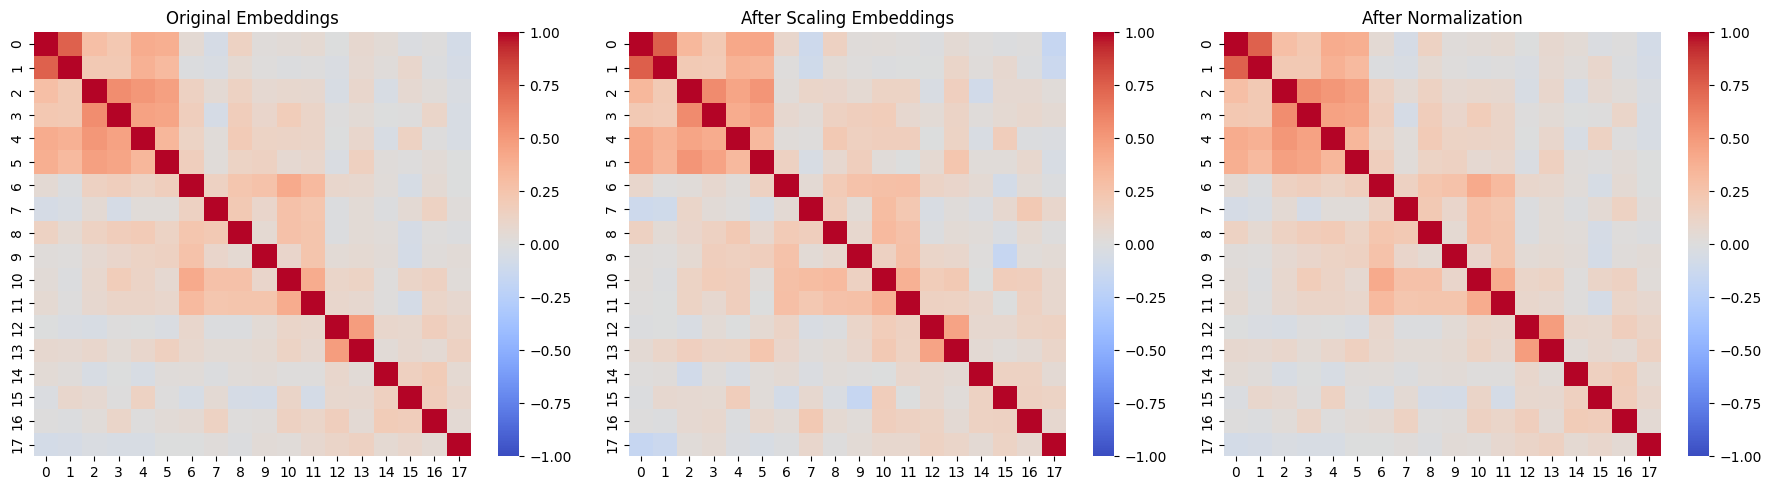

In [4]:
# Install necessary libraries
# !pip install sentence-transformers scikit-learn seaborn matplotlib

import numpy as np
from sentence_transformers import SentenceTransformer
import torch
import torch.nn.functional as F
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
def set_seeds(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seeds()

# Sentences grouped semantically
sentences = [
    # Animal group
    "The cat chases the mouse",
    "The dog chases the cat",
    "The lion hunts the gazelle", 
    "The wolf hunts the deer",
    "The tiger stalks its prey",
    "The fox catches the rabbit",
    # Nature group
    "The tree sways in the wind",
    "The flower blooms in spring", 
    "The grass grows in sunlight",
    "The river flows downstream",
    "The leaves rustle gently",
    "The rain falls softly",
    # Human group
    "The teacher writes on board",
    "The student reads the book",
    "The worker builds the house",
    "The chef cooks the meal", 
    "The artist paints the canvas",
    "The doctor helps patients"
]

# Assign group labels (0: Animal, 1: Nature, 2: Human)
groups = [0] * 6 + [1] * 6 + [2] * 6

# Load a pre-trained sentence-transformer model
model = SentenceTransformer('all-MiniLM-L6-v2')  # You can choose any suitable model

# Get embeddings
embeddings = model.encode(sentences, convert_to_tensor=True)

# Convert embeddings to numpy arrays for analysis
embeddings_np = embeddings.detach().cpu().numpy()

# Compute cosine similarities without normalization
original_sim = cosine_similarity(embeddings_np)

# Apply scaling to embeddings
def scale_embeddings(embeddings, scaling_factor=100):
    scaled_embeddings = embeddings.clone()
    dim = scaled_embeddings.shape[1]
    # Move scaling tensor to same device as embeddings
    scaling = torch.ones(dim, device=embeddings.device)
    scaling[:dim//2] = 1 / scaling_factor
    scaling[dim//2:] = scaling_factor
    scaled_embeddings = scaled_embeddings * scaling
    return scaled_embeddings

scaled_embeddings = scale_embeddings(embeddings)

# Compute cosine similarities after scaling
scaled_embeddings_np = scaled_embeddings.detach().cpu().numpy()
scaled_sim = cosine_similarity(scaled_embeddings_np)

# Apply L2 normalization to embeddings
normalized_embeddings = F.normalize(embeddings, p=2, dim=1)
normalized_embeddings_np = normalized_embeddings.detach().cpu().numpy()
normalized_sim = cosine_similarity(normalized_embeddings_np)

# Function to compute group metrics
def compute_group_metrics(similarities):
    """
    Compute within-group and between-group similarity metrics
    """
    metrics = {}
    for group_id, name in enumerate(['Animal', 'Nature', 'Human']):
        start_idx = group_id * 6
        end_idx = start_idx + 6

        # Calculate within-group similarity
        group_sim = similarities[start_idx:end_idx, start_idx:end_idx]
        mask = ~np.eye(group_sim.shape[0], dtype=bool)
        metrics[f'{name}_internal'] = group_sim[mask].mean()

        # Calculate between-group similarity with other groups
        other_indices = [i for i in range(len(sentences)) if not (start_idx <= i < end_idx)]
        between_sim = similarities[start_idx:end_idx][:, other_indices]
        metrics[f'{name}_external'] = between_sim.mean()

    return metrics

# Compute metrics
original_metrics = compute_group_metrics(original_sim)
scaled_metrics = compute_group_metrics(scaled_sim)
normalized_metrics = compute_group_metrics(normalized_sim)

# Print metrics for comparison
print("\n=== Original Embeddings (No Normalization) ===")
for k, v in original_metrics.items():
    print(f"{k}: {v:.3f}")

print("\n=== After Scaling Embeddings ===")
for k, v in scaled_metrics.items():
    print(f"{k}: {v:.3f}")

print("\n=== After Normalization ===")
for k, v in normalized_metrics.items():
    print(f"{k}: {v:.3f}")

# Visualize similarity matrices
plt.figure(figsize=(18, 5))

plt.subplot(131)
sns.heatmap(original_sim, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Original Embeddings")

plt.subplot(132)
sns.heatmap(scaled_sim, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("After Scaling Embeddings")

plt.subplot(133)
sns.heatmap(normalized_sim, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("After Normalization")

plt.tight_layout()
plt.show()

In [5]:
# Compute norms before scaling
norms_original = torch.norm(embeddings, dim=1)
print("Average norm before scaling:", norms_original.mean().item())

# Compute norms after scaling
norms_scaled = torch.norm(scaled_embeddings, dim=1)
print("Average norm after scaling:", norms_scaled.mean().item())

Average norm before scaling: 1.0
Average norm after scaling: 70.99166107177734


# GloVe

In [6]:
# Install necessary libraries
# !pip install torchtext scikit-learn seaborn matplotlib

import numpy as np
import torch
import torch.nn.functional as F
from torchtext.vocab import GloVe
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
def set_seeds(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seeds()

# Sentences grouped semantically
sentences = [
    # Animal group
    "The cat chases the mouse",
    "The dog chases the cat",
    "The lion hunts the gazelle", 
    "The wolf hunts the deer",
    "The tiger stalks its prey",
    "The fox catches the rabbit",
    # Nature group
    "The tree sways in the wind",
    "The flower blooms in spring", 
    "The grass grows in sunlight",
    "The river flows downstream",
    "The leaves rustle gently",
    "The rain falls softly",
    # Human group
    "The teacher writes on board",
    "The student reads the book",
    "The worker builds the house",
    "The chef cooks the meal", 
    "The artist paints the canvas",
    "The doctor helps patients"
]

# Assign group labels (0: Animal, 1: Nature, 2: Human)
groups = [0] * 6 + [1] * 6 + [2] * 6

# Load GloVe embeddings
# This may take some time to download the embeddings the first time
glove = GloVe(name='6B', dim=300)  # Using 300-dimensional GloVe embeddings

# Function to compute sentence embeddings by averaging word embeddings
def get_sentence_embedding(sentence, glove):
    words = sentence.lower().split()
    word_embeddings = []
    for word in words:
        if word in glove.stoi:
            word_embeddings.append(glove[word])
        else:
            # Handle out-of-vocabulary words (could use zeros or skip)
            word_embeddings.append(torch.zeros(glove.dim))
    if word_embeddings:
        sentence_embedding = torch.mean(torch.stack(word_embeddings), dim=0)
    else:
        # Handle empty embeddings (if no words are in the vocab)
        sentence_embedding = torch.zeros(glove.dim)
    return sentence_embedding

# Get embeddings for all sentences
embeddings = []
for sentence in sentences:
    embedding = get_sentence_embedding(sentence, glove)
    embeddings.append(embedding)
embeddings = torch.stack(embeddings)

# Convert embeddings to numpy arrays for analysis
embeddings_np = embeddings.detach().cpu().numpy()

# Compute cosine similarities without normalization
original_sim = cosine_similarity(embeddings_np)

# Apply scaling to embeddings
def scale_embeddings(embeddings, scaling_factor=100):
    scaled_embeddings = embeddings.clone()
    dim = scaled_embeddings.shape[1]
    scaling = torch.ones(dim)
    scaling[:dim//2] = 1 / scaling_factor
    scaling[dim//2:] = scaling_factor
    scaled_embeddings = scaled_embeddings * scaling
    return scaled_embeddings

scaled_embeddings = scale_embeddings(embeddings)

# Compute cosine similarities after scaling
scaled_embeddings_np = scaled_embeddings.detach().cpu().numpy()
scaled_sim = cosine_similarity(scaled_embeddings_np)

# Apply L2 normalization to embeddings
normalized_embeddings = F.normalize(embeddings, p=2, dim=1)
normalized_embeddings_np = normalized_embeddings.detach().cpu().numpy()
normalized_sim = cosine_similarity(normalized_embeddings_np)

# Function to compute group metrics
def compute_group_metrics(similarities):
    """
    Compute within-group and between-group similarity metrics
    """
    metrics = {}
    for group_id, name in enumerate(['Animal', 'Nature', 'Human']):
        start_idx = group_id * 6
        end_idx = start_idx + 6

        # Calculate within-group similarity
        group_sim = similarities[start_idx:end_idx, start_idx:end_idx]
        mask = ~np.eye(group_sim.shape[0], dtype=bool)
        metrics[f'{name}_internal'] = group_sim[mask].mean()

        # Calculate between-group similarity with other groups
        other_indices = [i for i in range(len(sentences)) if not (start_idx <= i < end_idx)]
        between_sim = similarities[start_idx:end_idx][:, other_indices]
        metrics[f'{name}_external'] = between_sim.mean()

    return metrics

# Compute metrics
original_metrics = compute_group_metrics(original_sim)
scaled_metrics = compute_group_metrics(scaled_sim)
normalized_metrics = compute_group_metrics(normalized_sim)

# Print metrics for comparison
print("\n=== Original Embeddings (No Normalization) ===")
for k, v in original_metrics.items():
    print(f"{k}: {v:.3f}")

print("\n=== After Scaling Embeddings ===")
for k, v in scaled_metrics.items():
    print(f"{k}: {v:.3f}")

print("\n=== After Normalization ===")
for k, v in normalized_metrics.items():
    print(f"{k}: {v:.3f}")

# Visualize similarity matrices
plt.figure(figsize=(18, 5))

plt.subplot(131)
sns.heatmap(original_sim, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Original Embeddings")

plt.subplot(132)
sns.heatmap(scaled_sim, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("After Scaling Embeddings")

plt.subplot(133)
sns.heatmap(normalized_sim, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("After Normalization")

plt.tight_layout()
plt.show()

# Compute norms to see the effect of scaling
norms_original = torch.norm(embeddings, dim=1)
norms_scaled = torch.norm(scaled_embeddings, dim=1)
norms_normalized = torch.norm(normalized_embeddings, dim=1)

print("\nAverage norm before scaling:", norms_original.mean().item())
print("Average norm after scaling:", norms_scaled.mean().item())
print("Average norm after normalization:", norms_normalized.mean().item())

OSError: dlopen(/Users/eli/code/cosine_sim_analysis/.venv/lib/python3.11/site-packages/torchtext/lib/libtorchtext.so, 0x0006): Symbol not found: __ZN3c105ErrorC1ENSt3__112basic_stringIcNS1_11char_traitsIcEENS1_9allocatorIcEEEES7_PKv
  Referenced from: <5436ECC1-6F45-386E-B542-D5F76A22B52C> /Users/eli/code/cosine_sim_analysis/.venv/lib/python3.11/site-packages/torchtext/lib/libtorchtext.so
  Expected in:     <BA9C42A5-EA1D-3784-80E1-73FBFDE05847> /Users/eli/code/cosine_sim_analysis/.venv/lib/python3.11/site-packages/torch/lib/libc10.dylib

# word2vec

In [7]:
# Install necessary libraries
# !pip install gensim scikit-learn seaborn matplotlib

import numpy as np
import torch
import torch.nn.functional as F
from gensim.models import KeyedVectors
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
def set_seeds(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)

set_seeds()

# Sentences grouped semantically
sentences = [
    # Animal group
    "The cat chases the mouse",
    "The dog chases the cat",
    "The lion hunts the gazelle", 
    "The wolf hunts the deer",
    "The tiger stalks its prey",
    "The fox catches the rabbit",
    # Nature group
    "The tree sways in the wind",
    "The flower blooms in spring", 
    "The grass grows in sunlight",
    "The river flows downstream",
    "The leaves rustle gently",
    "The rain falls softly",
    # Human group
    "The teacher writes on board",
    "The student reads the book",
    "The worker builds the house",
    "The chef cooks the meal", 
    "The artist paints the canvas",
    "The doctor helps patients"
]

# Assign group labels (0: Animal, 1: Nature, 2: Human)
groups = [0] * 6 + [1] * 6 + [2] * 6

# Load pre-trained Word2Vec embeddings
# You need to download the Google News pre-trained embeddings (about 1.5GB)
# You can download it from: https://code.google.com/archive/p/word2vec/

# For this example, we'll use a smaller pre-trained model available via gensim
from gensim.downloader import load as gensim_load

# Load the pre-trained Word2Vec model (this may take a few minutes)
word2vec_model = gensim_load('word2vec-google-news-300')  # 300-dimensional embeddings

# Function to compute sentence embeddings by averaging word embeddings
def get_sentence_embedding(sentence, model):
    words = sentence.lower().split()
    word_embeddings = []
    for word in words:
        if word in model.key_to_index:
            word_embeddings.append(torch.from_numpy(model[word]))
        else:
            # Handle out-of-vocabulary words by assigning zero vector
            word_embeddings.append(torch.zeros(model.vector_size))
    if word_embeddings:
        sentence_embedding = torch.mean(torch.stack(word_embeddings), dim=0)
    else:
        # Handle empty embeddings
        sentence_embedding = torch.zeros(model.vector_size)
    return sentence_embedding

# Get embeddings for all sentences
embeddings = []
for sentence in sentences:
    embedding = get_sentence_embedding(sentence, word2vec_model)
    embeddings.append(embedding)
embeddings = torch.stack(embeddings)

# Convert embeddings to numpy arrays for analysis
embeddings_np = embeddings.detach().cpu().numpy()

# Compute cosine similarities without normalization
original_sim = cosine_similarity(embeddings_np)

# Apply scaling to embeddings
def scale_embeddings(embeddings, scaling_factor=100):
    scaled_embeddings = embeddings.clone()
    dim = scaled_embeddings.shape[1]
    scaling = torch.ones(dim)
    scaling[:dim//2] = 1 / scaling_factor
    scaling[dim//2:] = scaling_factor
    scaled_embeddings = scaled_embeddings * scaling
    return scaled_embeddings

scaled_embeddings = scale_embeddings(embeddings)

# Compute cosine similarities after scaling
scaled_embeddings_np = scaled_embeddings.detach().cpu().numpy()
scaled_sim = cosine_similarity(scaled_embeddings_np)

# Apply L2 normalization to embeddings
normalized_embeddings = F.normalize(embeddings, p=2, dim=1)
normalized_embeddings_np = normalized_embeddings.detach().cpu().numpy()
normalized_sim = cosine_similarity(normalized_embeddings_np)

# Function to compute group metrics
def compute_group_metrics(similarities):
    """
    Compute within-group and between-group similarity metrics
    """
    metrics = {}
    for group_id, name in enumerate(['Animal', 'Nature', 'Human']):
        start_idx = group_id * 6
        end_idx = start_idx + 6

        # Calculate within-group similarity
        group_sim = similarities[start_idx:end_idx, start_idx:end_idx]
        mask = ~np.eye(group_sim.shape[0], dtype=bool)
        metrics[f'{name}_internal'] = group_sim[mask].mean()

        # Calculate between-group similarity with other groups
        other_indices = [i for i in range(len(sentences)) if not (start_idx <= i < end_idx)]
        between_sim = similarities[start_idx:end_idx][:, other_indices]
        metrics[f'{name}_external'] = between_sim.mean()

    return metrics

# Compute metrics
original_metrics = compute_group_metrics(original_sim)
scaled_metrics = compute_group_metrics(scaled_sim)
normalized_metrics = compute_group_metrics(normalized_sim)

# Print metrics for comparison
print("\n=== Original Embeddings (No Normalization) ===")
for k, v in original_metrics.items():
    print(f"{k}: {v:.3f}")

print("\n=== After Scaling Embeddings ===")
for k, v in scaled_metrics.items():
    print(f"{k}: {v:.3f}")

print("\n=== After Normalization ===")
for k, v in normalized_metrics.items():
    print(f"{k}: {v:.3f}")

# Visualize similarity matrices
plt.figure(figsize=(18, 5))

plt.subplot(131)
sns.heatmap(original_sim, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Original Embeddings")

plt.subplot(132)
sns.heatmap(scaled_sim, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("After Scaling Embeddings")

plt.subplot(133)
sns.heatmap(normalized_sim, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("After Normalization")

plt.tight_layout()
plt.show()

# Compute norms to see the effect of scaling
norms_original = torch.norm(embeddings, dim=1)
norms_scaled = torch.norm(scaled_embeddings, dim=1)
norms_normalized = torch.norm(normalized_embeddings, dim=1)

print("\nAverage norm before scaling:", norms_original.mean().item())
print("Average norm after scaling:", norms_scaled.mean().item())
print("Average norm after normalization:", norms_normalized.mean().item())

ImportError: cannot import name 'triu' from 'scipy.linalg' (/Users/eli/code/cosine_sim_analysis/.venv/lib/python3.11/site-packages/scipy/linalg/__init__.py)